In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import seaborn as sns

In [3]:
pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.8 MB/s eta 0:00:00


In [4]:
from kerastuner.tuners import RandomSearch

<ipython-input-4-94471a811b41>:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [5]:
train = pd.read_csv('/min_train.csv')
val = pd.read_csv('/min_val.csv')
test = pd.read_csv('/min_test.csv')
test2 = pd.read_csv('/min_test2.csv')

In [6]:
train_rsi = train['RSI']
val_rsi = val['RSI']
test_rsi = test['RSI']
test2_rsi = test2['RSI']

train_rsi = train_rsi.dropna()

In [7]:
train_mean = train_rsi.mean()
train_std = train_rsi.std()

train_nr = (train_rsi - train_mean)/train_std
val_nr = (val_rsi - train_mean)/train_std
test_nr = (test_rsi - train_mean)/train_std

In [8]:
def create_sequences(data, input_sequence_length, forecast_horizon):
    X, y = [], []
    for i in range(len(data) - input_sequence_length - forecast_horizon + 1):
        X.append(data[i:(i + input_sequence_length)])
        y.append(data[(i + input_sequence_length):(i + input_sequence_length + forecast_horizon)])
    return np.array(X), np.array(y)

In [9]:
input_sequence_length = 20
forecast_horizon = 1

X_train, y_train = create_sequences(train_nr, input_sequence_length, forecast_horizon)
X_val, y_val = create_sequences(val_nr, input_sequence_length, forecast_horizon)
X_test, y_test = create_sequences(test_nr, input_sequence_length, forecast_horizon)

# Display the shape of the created sequences for verification
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((42284, 20), (42284, 1), (10180, 20), (10180, 1), (10690, 20), (10690, 1))

In [10]:
# change the shape to fit the LSTM model

X_train = X_train[:, :, np.newaxis]
X_val = X_val[:, :, np.newaxis]
X_test = X_test[:, :, np.newaxis]


y_train = y_train[:, :, np.newaxis]
y_val = y_val[:, :, np.newaxis]
y_test = y_test[:, :, np.newaxis]

# Display the shape of the created sequences for verification
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((42284, 20, 1),
 (42284, 1, 1),
 (10180, 20, 1),
 (10180, 1, 1),
 (10690, 20, 1),
 (10690, 1, 1))

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))


train_dataset = train_dataset.batch(32)

val_dataset = val_dataset.batch(32)

test_dataset = test_dataset.batch(32)

In [12]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

In [23]:
OUT_STEPS = 1
num_features = 1

In [22]:
def build_model(hp):
    model = Sequential([
        layers.LSTM(
            units=hp.Int('units', min_value=50, max_value=300, step=50),
            input_shape=(20, 1)  # Assuming input_shape is always (20, 1)
        ),
        layers.Dense(
            OUT_STEPS * num_features,
            kernel_initializer=tf.initializers.zeros()
        ),
        layers.Reshape([OUT_STEPS, num_features])
    ])

    model.compile(
        loss='mse',
        optimizer=Adam(
            learning_rate=hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])
        ),
        metrics=['mean_absolute_percentage_error']
    )
    return model

In [24]:
tuner = RandomSearch(
    build_model,
    objective='val_loss',  # Targeting to minimize the validation loss
    max_trials=10,  # Number of trials to run (different model configurations)
    executions_per_trial=1,
    directory='my_dir',
    project_name='lstm_tuning'
)

In [25]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [28]:
tuner.search(
    X_train, y_train,  # assuming x_train and y_train are prepared
    epochs=50,
    validation_split=0.2,  # 20% of the data for validation
    callbacks=[stop_early]
)

Trial 10 Complete [00h 25m 52s]
val_loss: 0.6657307744026184

Best val_loss So Far: 0.6493170857429504
Total elapsed time: 02h 08m 59s


In [29]:
best_model = tuner.get_best_models(num_models=1)[0]

In [30]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 300)               362400    
                                                                 
 dense (Dense)               (None, 1)                 301       
                                                                 
 reshape (Reshape)           (None, 1, 1)              0         
                                                                 
Total params: 362701 (1.38 MB)
Trainable params: 362701 (1.38 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [32]:
loss, mape = best_model.evaluate(X_test, y_test)  # assuming x_test and y_test are available
print("Loss:", loss)
print("MAPE:", mape)

335/335 [==============================] - 8s 21ms/step - loss: 0.6624 - mean_absolute_percentage_error: 329.9266
Loss: 0.6624152660369873
MAPE: 329.92657470703125


In [33]:
def plot_results(X_train,X_val,X_test,y_train,y_val,y_test, model):
    # Creating indices for plotting
    train_x = np.arange(len(y_train))
    val_x = np.arange(len(y_val))
    test_x = np.arange(len(y_test))

    # Making predictions
    pred_train = model.predict(X_train)
    pred_val = model.predict(X_val)
    pred_test = model.predict(X_test)

    # Creating a figure and subplots
    plt.figure(figsize=(20, 15))  # Adjusted for better vertical display

    # Subplot for the training set
    plt.subplot(3, 1, 1)  # 3 rows, 1 column, 1st subplot
    plt.plot(train_x, y_train[:, 0], label='Actual')
    plt.plot(train_x, pred_train[:, 0], label='Predicted')
    plt.title('Training Set')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()

    # Subplot for the validation set
    plt.subplot(3, 1, 2)  # 3 rows, 1 column, 2nd subplot
    plt.plot(val_x, y_val[:, 0], label='Actual')
    plt.plot(val_x, pred_val[:, 0], label='Predicted')
    plt.title('Validation Set')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()

    # Subplot for the test set
    plt.subplot(3, 1, 3)  # 3 rows, 1 column, 3rd subplot
    plt.plot(test_x, y_test[:, 0], label='Actual')
    plt.plot(test_x, pred_test[:, 0], label='Predicted')
    plt.title('Test Set')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()

    # Show plot
    plt.tight_layout()
    plt.show()

335/335 [==============================] - 6s 18ms/step


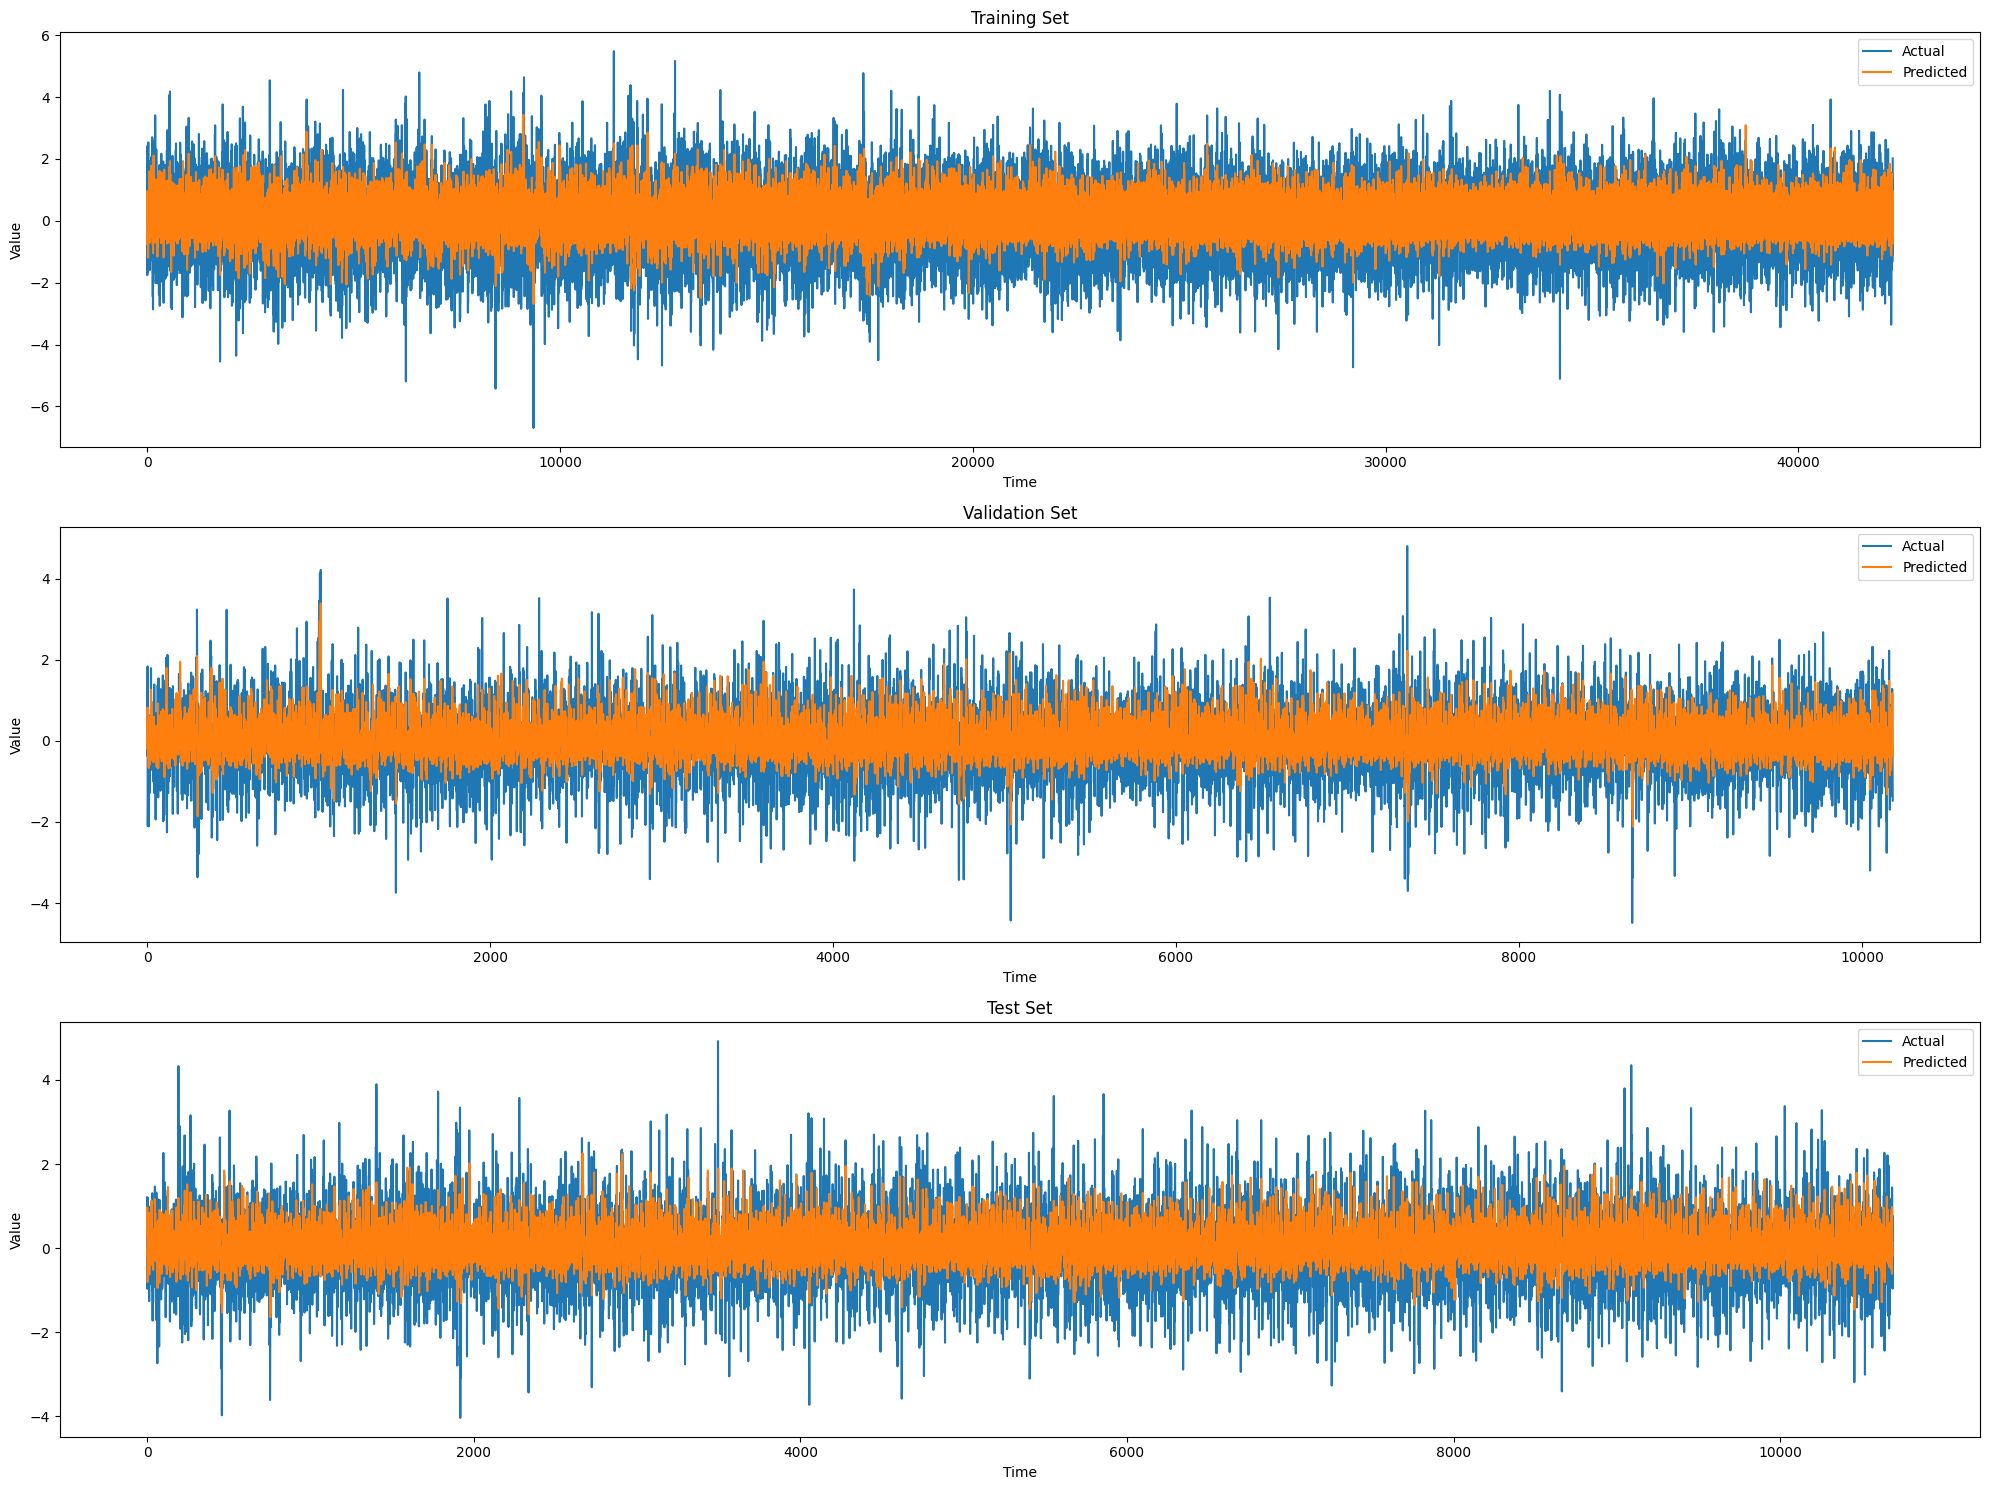

In [34]:
plot_results(X_train,X_val,X_test,y_train,y_val,y_test, best_model)